In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/archive.zip

Archive:  gdrive/My Drive/archive.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  in

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
import glob 
from PIL import Image

In [4]:
#data path
no_data_path = Path('/content/no')
yes_data_path = Path('/content/yes')

In [5]:
#JPG path
no_jpg_path = list(no_data_path.glob(r"*.jpg"))
yes_jpg_path = list(yes_data_path.glob(r"*.jpg"))

In [6]:
print(no_jpg_path[0:5])
print('------'*20)
print(yes_jpg_path[0:5])

[PosixPath('/content/no/no273.jpg'), PosixPath('/content/no/no271.jpg'), PosixPath('/content/no/no1099.jpg'), PosixPath('/content/no/no789.jpg'), PosixPath('/content/no/no253.jpg')]
------------------------------------------------------------------------------------------------------------------------
[PosixPath('/content/yes/y735.jpg'), PosixPath('/content/yes/y194.jpg'), PosixPath('/content/yes/y1422.jpg'), PosixPath('/content/yes/y983.jpg'), PosixPath('/content/yes/y805.jpg')]


In [7]:
#JPG labels
yes_no_list = []

for no_jpg in no_jpg_path:
    yes_no_list.append(no_jpg)
    
for yes_jpg in yes_jpg_path:
    yes_no_list.append(yes_jpg)

In [8]:
print(yes_no_list[0:10])

[PosixPath('/content/no/no273.jpg'), PosixPath('/content/no/no271.jpg'), PosixPath('/content/no/no1099.jpg'), PosixPath('/content/no/no789.jpg'), PosixPath('/content/no/no253.jpg'), PosixPath('/content/no/no264.jpg'), PosixPath('/content/no/no31.jpg'), PosixPath('/content/no/no1105.jpg'), PosixPath('/content/no/no57.jpg'), PosixPath('/content/no/no707.jpg')]


In [9]:
jpg_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], yes_no_list))

In [10]:
jpg_labels[0:10]

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']

In [11]:
print(jpg_labels.count('no'))
print(jpg_labels.count('yes'))

1500
1500


In [12]:
#TRANSFORMATION TO SERIES STRUCTURE
jpg_path_series = pd.Series(yes_no_list, name='jpg').astype(str)
jpg_category_series = pd.Series(jpg_labels, name='category')

In [13]:
#TRANSFORMATION TO DATAFRAME STRUCTURE, TRAIN
main_train_data = pd.concat([jpg_path_series, jpg_category_series], axis=1)

In [14]:
print(main_train_data.head(-1))

                         jpg category
0      /content/no/no273.jpg       no
1      /content/no/no271.jpg       no
2     /content/no/no1099.jpg       no
3      /content/no/no789.jpg       no
4      /content/no/no253.jpg       no
...                      ...      ...
2994  /content/yes/y1481.jpg      yes
2995   /content/yes/y974.jpg      yes
2996  /content/yes/y1492.jpg      yes
2997   /content/yes/y292.jpg      yes
2998  /content/yes/y1085.jpg      yes

[2999 rows x 2 columns]


In [15]:
prediction_path = Path('/content/pred')
Test_jpg_path = list(prediction_path.glob(r'*.jpg'))
print(Test_jpg_path[:5])

[PosixPath('/content/pred/pred24.jpg'), PosixPath('/content/pred/pred6.jpg'), PosixPath('/content/pred/pred37.jpg'), PosixPath('/content/pred/pred5.jpg'), PosixPath('/content/pred/pred52.jpg')]


In [16]:
#TEST, validation
Test_jpg_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], 
                          Test_jpg_path))

In [17]:
print(Test_jpg_labels[0:5])

['pred', 'pred', 'pred', 'pred', 'pred']


In [18]:
Test_jpg_path_series = pd.Series(Test_jpg_path, name='jpg').astype(str)
Test_jpg_labels_series = pd.Series(Test_jpg_labels, name='category')

In [19]:
Test_data = pd.concat([Test_jpg_path_series, Test_jpg_labels_series], axis=1)

In [20]:
Test_data.head()

,jpg,category
0,/content/pred/pred24.jpg,pred
1,/content/pred/pred6.jpg,pred
2,/content/pred/pred37.jpg,pred
3,/content/pred/pred5.jpg,pred
4,/content/pred/pred52.jpg,pred


In [21]:
#Shuffling
main_train_data = main_train_data.sample(frac=1).reset_index(drop=True)

In [22]:
main_train_data.head()

,jpg,category
0,/content/yes/y723.jpg,yes
1,/content/no/no320.jpg,no
2,/content/no/no1143.jpg,no
3,/content/no/no971.jpg,no
4,/content/no/no660.jpg,no


Text(0.5, 1.0, 'no')

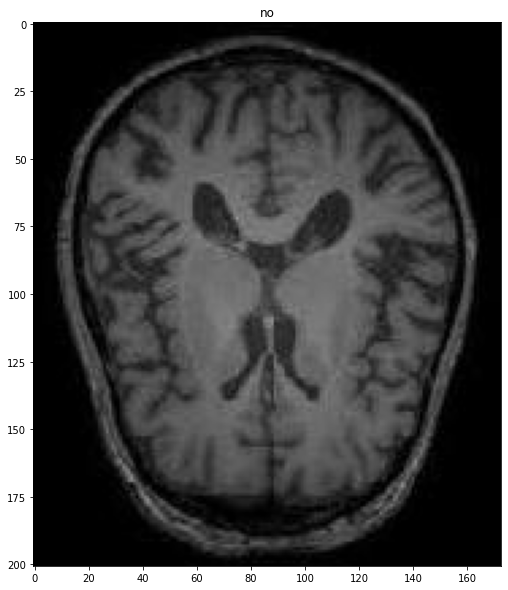

In [23]:
#Visualization
figure = plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(main_train_data['jpg'][10]))
plt.title(main_train_data['category'][10])

Text(0.5, 1.0, 'yes')

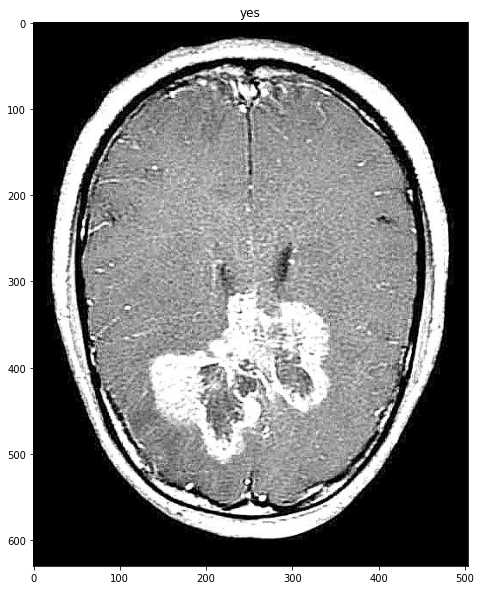

In [24]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(main_train_data['jpg'][2997]))
plt.title(main_train_data['category'][2997])

Text(0.5, 1.0, 'no')

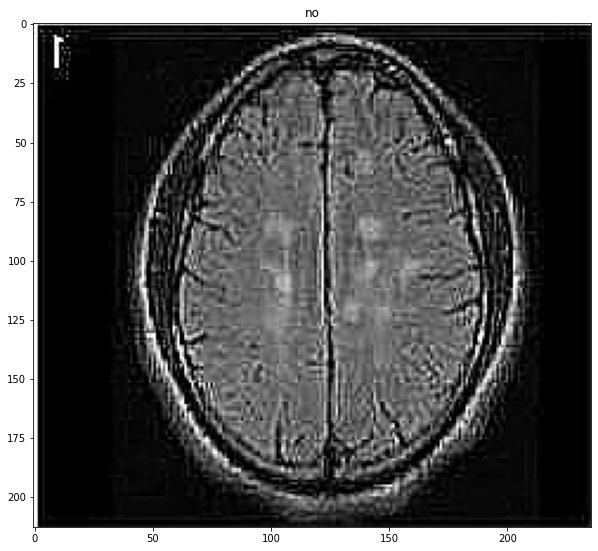

In [25]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(main_train_data['jpg'][1]))
plt.title(main_train_data['category'][1])

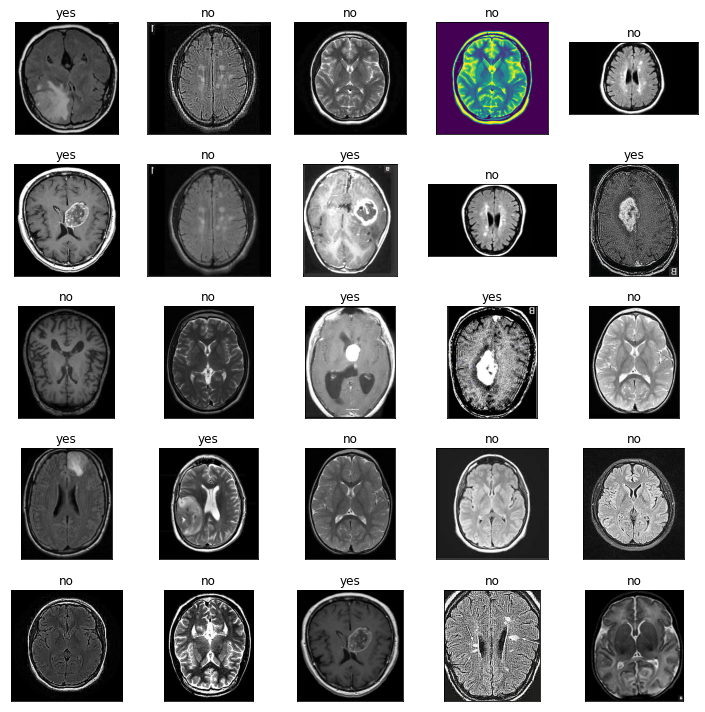

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                        subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(main_train_data['jpg'][i]))
    ax.set_title(main_train_data['category'][i])
plt.tight_layout()
plt.show()

In [27]:
# Split data
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(main_train_data, train_size=0.9, random_state=42)

In [28]:
train_data.shape

(2700, 2)

In [29]:
test_data.shape

(300, 2)

In [30]:
train_data.head()

,jpg,category
433,/content/yes/y1174.jpg,yes
1151,/content/yes/y1493.jpg,yes
73,/content/no/no1127.jpg,no
1536,/content/yes/y1328.jpg,yes
2709,/content/yes/y593.jpg,yes


In [31]:
#Image generator
generator_basic = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.1)

In [32]:
#applying image generator and transformation to Tensor Flow.
train_set = generator_basic.flow_from_dataframe(train_data,
                                               x_col='jpg',
                                               y_col='category',
                                               color_mode='grayscale',
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=20,
                                               target_size=(224, 224))

Found 2430 validated image filenames belonging to 2 classes.


In [33]:
val_set = generator_basic.flow_from_dataframe(train_data,
                                             x_col='jpg',
                                             y_col='category',
                                             color_mode='grayscale',
                                             class_model='categorical',
                                             subset='validation',
                                             batch_size=20,
                                             target_size=(224, 224))

Found 270 validated image filenames belonging to 2 classes.


In [34]:
test_set = generator_basic.flow_from_dataframe(test_data,
                                              x_col='jpg',
                                              y_col='category',
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              batch_size=20,
                                              target_size=(224, 224))

Found 300 validated image filenames belonging to 2 classes.


In [35]:
#image set checking
for data_batch, label_batch in train_set:
    print('data shape: ', data_batch.shape)
    print('label shape :', label_batch.shape)
    break

data shape:  (20, 224, 224, 1)
label shape : (20, 2)


In [36]:
for data_batch, label_batch in test_set:
    print('data shape: ', data_batch.shape)
    print('label shape :', label_batch.shape)
    break

data shape:  (20, 224, 224, 1)
label shape : (20, 2)


In [37]:
print(train_set.class_indices)
print(train_set.classes[0:5])
print(train_set.image_shape)

{'no': 0, 'yes': 1}
[0, 1, 1, 0, 0]
(224, 224, 1)


In [38]:
print(val_set.class_indices)
print(val_set.classes[0:5])
print(val_set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 0, 1, 1]
(224, 224, 1)


In [39]:
print(test_set.class_indices)
print(test_set.classes[0:5])
print(test_set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 0, 0, 1]
(224, 224, 1)


In [40]:
#CNN with conv2D

Model = Sequential([
    Conv2D(32,(5,5),activation="relu",input_shape=(224,224,1)),
    MaxPool2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Dropout(0.2),
    
    Conv2D(256, (3,3),activation="relu"),
    MaxPool2D((2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [41]:
Model.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [42]:
ANN_Model = Model.fit(train_set,validation_data=val_set,
                      epochs=30,steps_per_epoch=120)

Epoch 1/30
120/120 [==============================] - 423s 4s/step - loss: 0.6348 - accuracy: 0.7180 - val_loss: 0.5149 - val_accuracy: 0.7296
Epoch 2/30
120/120 [==============================] - 425s 4s/step - loss: 0.4470 - accuracy: 0.7987 - val_loss: 0.4477 - val_accuracy: 0.8111
Epoch 3/30
120/120 [==============================] - 434s 4s/step - loss: 0.3336 - accuracy: 0.8536 - val_loss: 0.2578 - val_accuracy: 0.9111
Epoch 4/30
120/120 [==============================] - 431s 4s/step - loss: 0.2394 - accuracy: 0.8979 - val_loss: 0.2453 - val_accuracy: 0.9148
Epoch 5/30
120/120 [==============================] - 424s 4s/step - loss: 0.1842 - accuracy: 0.9272 - val_loss: 0.1837 - val_accuracy: 0.9296
Epoch 6/30
120/120 [==============================] - 425s 4s/step - loss: 0.1452 - accuracy: 0.9481 - val_loss: 0.2060 - val_accuracy: 0.9444
Epoch 7/30
120/120 [==============================] - 425s 4s/step - loss: 0.1126 - accuracy: 0.9573 - val_loss: 0.2470 - val_accuracy: 0.9333

In [43]:
history = ANN_Model.history

val_losses = history['val_loss']
val_acc = history['val_accuracy']
acc = history['accuracy']
losses = history['loss']
epochs = range(1, len(val_losses)+1)

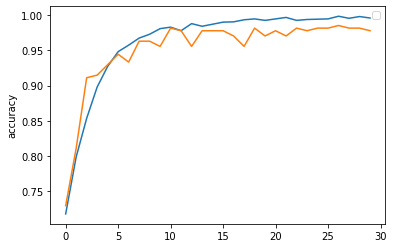

In [44]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('accuracy')
plt.legend()
plt.show()

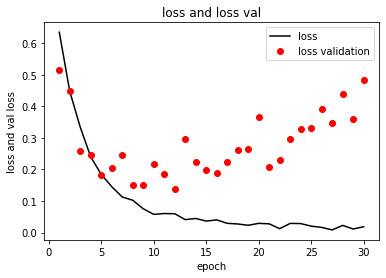

In [45]:
plt.plot(epochs, losses, 'k-', label='loss')
plt.plot(epochs, val_losses, 'ro', label='loss validation')
plt.title('loss and loss val')
plt.xlabel('epoch')
plt.ylabel('loss and val loss')
plt.legend()
plt.show()

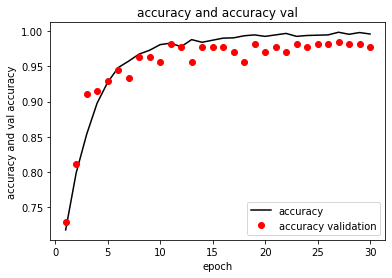

In [46]:
plt.plot(epochs, acc, 'k-', label='accuracy')
plt.plot(epochs, val_acc, 'ro', label='accuracy validation')
plt.title('accuracy and accuracy val')
plt.xlabel('epoch')
plt.ylabel('accuracy and val accuracy')
plt.legend()
plt.show()

In [47]:
model_results = Model.evaluate(test_set, verbose=False)
print("LOSS: " + "%.4f" % model_results[0])
print("ACCURACY: " + "%.2f" % model_results[1])

LOSS: 0.0867
ACCURACY: 0.99
